<a href="https://colab.research.google.com/github/TaoM1992/ml_lab_finalproject/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Lab Final Project**

### Modeling Earthquake Damage


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import *
# from category_encoders import *
from sklearn.compose import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition   import PCA
from sklearn.base            import BaseEstimator
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance

#### Data Loading

In [14]:
X = pd.read_csv('https://raw.githubusercontent.com/TaoM1992/ml_lab_finalproject/main/train_values.csv')
y = pd.read_csv('https://raw.githubusercontent.com/TaoM1992/ml_lab_finalproject/main/train_labels.csv')
y = y['damage_grade']

#### Data Preprocessing

In [ ]:
# preprocessing
categorical_columns = (X.dtypes == object)
cnt_columns = (X.dtypes == 'int64')
con_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessing = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('continuous', con_pipe, cnt_columns)])


#### Creating Pipeline
Since this data has more than 250k records, in order to speed up search process I decided to randomly search within a single algorithm rather than cross different algorithms.

- pipeline 1: automatic parameter tuning of RandomForestClassifier
- pipeline 2: automatic hyperparameter tuning of ExtraTreesClassifier
- pipeline 3: stacking the best model (with tuned hyperparameters) with GradientBoostingClassifier

In [ ]:
# pipeline 1: automatic parameter tuning of RandomForestClassifier
pipe1 = Pipeline([('preprocessing', preprocessing), 
                  ('clf', RandomForestClassifier(n_jobs=-1))])

In [5]:
# hyperparameters tuned: 
## criterion - to see whether loss function would impact the result; 
## max_features - maximum sub features selected; 
## n_estimators - to see if more trees would help; 
## max_depth - trees with higher height would get more purity; 
## oob_score - with out of bag sample as validation set normally help get better results; 
## class_weight - to take calss weight into account.
hyperparameters1 = dict(clf__criterion = ['gini', 'entropy'],
                      clf__max_features = ['auto', 'sqrt', 'log2'],
                      clf__n_estimators = [50, 100, 150, 200],
                      clf__max_depth = [20, 50, 100],
                      clf__oob_score = [False, True],
                      clf__class_weight = ['balanced', 'balanced_subsample', None])

In [ ]:
clf_rand1 = RandomizedSearchCV(estimator=pipe1,
                              param_distributions=hyperparameters1,
                              n_iter=20,
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

##### Metric for model evaluation: F1 micro averaged score
The reason why I used f1 score is because I want to emphasize both recall and precision. Although the target variable in this data is not very imbalanced (class 1: 10%, class 2: 57%, class 3: 33%), I still want to aggregate the contributions of all classes to compute the average metric, and micro averaged f1 score can handle this because it takes sample number of each class into account. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=999)
best_model1 = clf_rand1.fit(X_train, y_train)
print(clf_rand1.best_estimator_.get_params()['clf'])
pred1 = best_model1.best_estimator_.predict(X_val)
f1_score(y_val, pred1, average='micro')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 122.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


0.7123605163389665

In [ ]:
# pipeline 2: automatic parameter tuning of ExtraTreesClassifier
pipe2 = Pipeline([('preprocessing', preprocessing), 
                  ('clf', ExtraTreesClassifier(n_jobs=-1))])

In [6]:
# hyperparameters tuned: 
## criterion - to see whether loss function would impact the result; 
## max_features - maximum sub features selected; 
## n_estimators - to see if more trees would help; 
## max_leaf_nodes - to see if more leaf nodes would help, normally more leaf nodes help impurity.
## max_depth - trees with higher height would get more impurity; 
## bootstrap - I want to see if more randomness would help the results.
## oob_score - with out of bag sample as validation set normally help get better results; 
## class_weight - to take calss weight into account.
hyperparameters2 = dict(clf__criterion = ['gini', 'entropy'],
                        clf__max_features = ['auto', 'sqrt', 'log2'],
                        clf__n_estimators = [50, 100, 150, 200],
                        clf__max_leaf_nodes = [50, 100, 150, 200],
                        clf__max_depth = [20, 50],
                        clf__bootstrap = [False, True],
                        clf__oob_score = [False, True],
                        clf__class_weight = ['balanced', 'balanced_subsample', None])

In [ ]:
clf_rand2 = RandomizedSearchCV(estimator=pipe2,
                              param_distributions=hyperparameters2,
                              n_iter=25,
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

In [14]:
best_model2 = clf_rand2.fit(X_train, y_train)
print(clf_rand2.best_estimator_.get_params()['clf'])
pred2 = best_model2.best_estimator_.predict(X_val)
f1_score(y_val, pred2, average='micro')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 34.2min finished


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=50, max_features='sqrt',
                     max_leaf_nodes=150, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=True, random_state=None, verbose=0,
                     warm_start=False)


0.6135439210449571

We can observe that ExtraTreesClassifier performed worse than RandomForestClassifier in this case.

In [ ]:
# stacking best estimator with GradientBoosting
estimators = [('rf', clf_rand1.best_estimator_.get_params()['clf'])]
final_estimator = GradientBoostingClassifier()
classifier = StackingClassifier(estimators=estimators,
                        final_estimator=final_estimator)

In [26]:
# pipeline 3: stacking different estimators
pipe3 = Pipeline([('preprocessing', preprocessing), 
                  ('clf', classifier)])

In [27]:
pipe3.fit(X_train, y_train)
pred3 = pipe3.predict(X_val)
f1_score(y_val, pred3, average='micro')

0.7121609798775154

It seems like stacking RandomForestClassifier with GradientBostingClassifier has similar results as using only RandomForestClassifier. However we prefer simpler model.

In [21]:
# pipeline 4: best model + PCA
pipe4 = Pipeline([('preprocessing', preprocessing), 
                  ('PCA', PCA(n_components = 'mle')),
                  ('clf', clf_rand1.best_estimator_.get_params()['clf'])])

In [22]:
pipe4.fit(X_train, y_train)
pred4 = pipe4.predict(X_val)
f1_score(y_val, pred4, average='micro')

0.6742183542846618

We can observe that PCA doesn't help much, which makes sense because it only takes important features. 

#### Final Pipeline

In [23]:
# final pipeline: 
best_pipe = Pipeline([('preprocessing', preprocessing), 
                      ('clf', clf_rand1.best_estimator_.get_params()['clf'])])

In [24]:
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_val)
f1_score(y_val, y_pred, average='micro')

0.7129284278061734

#### Confusion Matrix

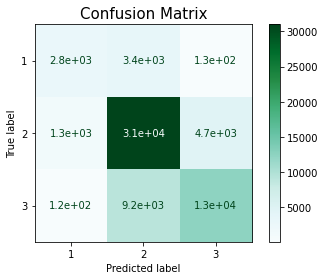

In [28]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(best_pipe.fit(X_train, y_train), X_val, y_val,
                             cmap=plt.cm.BuGn)
disp.ax_.set_title('Confusion Matrix', fontsize = 15)
plt.show()

- Conclusion: the best model predict the medium damage the best, however it predict badly the low damage. It makes sense because in real life low damage is harder to identify comparing to medium and high damge. 

#### Feature Importance

In [31]:
# feature importance
model = best_pipe.fit(X_train, y_train)
imp = permutation_importance(model, 
                           X_val, y_val, 
                           n_repeats=30,
                           random_state=42)

for i in imp.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8}"
          f"{imp.importances_mean[i]:.3f}"
          f" ± {imp.importances_std[i]:.3f}")

geo_level_1_id0.116 ± 0.001
geo_level_2_id0.031 ± 0.001
has_superstructure_mud_mortar_stone0.022 ± 0.001
foundation_type0.019 ± 0.001
other_floor_type0.018 ± 0.001
roof_type0.016 ± 0.001
geo_level_3_id0.015 ± 0.001
ground_floor_type0.015 ± 0.001
height_percentage0.013 ± 0.001
age     0.011 ± 0.001
has_superstructure_timber0.011 ± 0.001
count_floors_pre_eq0.010 ± 0.001
area_percentage0.009 ± 0.001
position0.005 ± 0.001
has_superstructure_cement_mortar_brick0.005 ± 0.000
land_surface_condition0.005 ± 0.001
has_superstructure_bamboo0.003 ± 0.000
has_superstructure_stone_flag0.003 ± 0.000
has_superstructure_adobe_mud0.002 ± 0.000
has_superstructure_mud_mortar_brick0.002 ± 0.000
has_superstructure_rc_non_engineered0.002 ± 0.000
count_families0.001 ± 0.001
plan_configuration0.001 ± 0.000
has_secondary_use0.001 ± 0.000
legal_ownership_status0.001 ± 0.000
has_superstructure_cement_mortar_stone0.001 ± 0.000
has_secondary_use_agriculture0.001 ± 0.000
building_id0.001 ± 0.001
has_superstructure_o

Obviously the geo_level_1_id and geo_level_2_id are the most two important features to predict target variables. These two features are geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). This explains that geographic information has great impact on predicting earthquake damage level. 